In [ ]:
# Cell 1: Install required packages
!pip install ultralytics opencv-python matplotlib numpy tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 977.1/977.1 kB 26.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 67.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 61.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalli

In [ ]:
# Cell 2: Import libraries
import os
import json
import glob
import shutil
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from ultralytics import YOLO
from sklearn.model_selection import train_test_split

In [ ]:
# Cell 3: Define paths and create directory structure
# Update these paths to your actual data locations
dataset_dir = "/content/drive/MyDrive/full_cars_images"  # Base directory where you downloaded the dataset
train_images_dir = os.path.join(dataset_dir, "train", "img")  # Directory containing train images
train_annotations_dir = os.path.join(dataset_dir, "train", "ann")  # Directory containing train JSON annotations
test_images_dir = os.path.join(dataset_dir, "test", "img")  # Directory containing test images
test_annotations_dir = os.path.join(dataset_dir, "test", "ann")  # Directory containing test JSON annotations

# Create YOLO dataset directory structure
yolo_dataset_dir = "license_plate_detection"
os.makedirs(os.path.join(yolo_dataset_dir, "images", "train"), exist_ok=True)
os.makedirs(os.path.join(yolo_dataset_dir, "images", "val"), exist_ok=True)
os.makedirs(os.path.join(yolo_dataset_dir, "labels", "train"), exist_ok=True)
os.makedirs(os.path.join(yolo_dataset_dir, "labels", "val"), exist_ok=True)

print(f"Created YOLO dataset directory structure in {yolo_dataset_dir}")

Created YOLO dataset directory structure in license_plate_detection


In [ ]:
# Cell 4: Convert JSON annotations to YOLO format
def convert_json_to_yolo(json_path, img_width, img_height):
    """
    Convert JSON annotation to YOLO format (class_id, x_center, y_center, width, height)
    All values are normalized between 0 and 1
    """
    with open(json_path, 'r') as f:
        data = json.load(f)

    # Safety check if size is not in the JSON
    if 'size' in data:
        img_width = data['size']['width']
        img_height = data['size']['height']

    yolo_annotations = []

    for obj in data['objects']:
        if obj['classTitle'] == 'license plate':
            # Get coordinates (assuming rectangle format with exterior points)
            points = obj['points']['exterior']
            x1, y1 = points[0]
            x2, y2 = points[1]

            # Convert to YOLO format (class_id, x_center, y_center, width, height)
            x_center = (x1 + x2) / 2 / img_width
            y_center = (y1 + y2) / 2 / img_height
            width = abs(x2 - x1) / img_width
            height = abs(y2 - y1) / img_height

            # Class ID is 0 for license plate (single class)
            yolo_annotations.append(f"0 {x_center} {y_center} {width} {height}")

    return yolo_annotations

In [ ]:
# Cell 5 (Modified): Prepare dataset - find all images and their annotations
# List all train image files
train_image_files = glob.glob(os.path.join(train_images_dir, "*.jpg")) + \
                   glob.glob(os.path.join(train_images_dir, "*.JPG")) + \
                   glob.glob(os.path.join(train_images_dir, "*.png")) + \
                   glob.glob(os.path.join(train_images_dir, "*.jpeg"))

# List all test image files
test_image_files = glob.glob(os.path.join(test_images_dir, "*.jpg")) + \
                  glob.glob(os.path.join(test_images_dir, "*.JPG")) + \
                  glob.glob(os.path.join(test_images_dir, "*.png")) + \
                  glob.glob(os.path.join(test_images_dir, "*.jpeg"))

print(f"Found {len(train_image_files)} training images")
print(f"Found {len(test_image_files)} test images")

# Create mapping of image filename to annotation filename
train_image_to_annotation = {}
for image_path in train_image_files:
    base_name = os.path.basename(image_path)
    json_name = base_name + ".json"
    json_path = os.path.join(train_annotations_dir, json_name)

    if os.path.exists(json_path):
        train_image_to_annotation[image_path] = json_path

test_image_to_annotation = {}
for image_path in test_image_files:
    base_name = os.path.basename(image_path)
    json_name = base_name + ".json"
    json_path = os.path.join(test_annotations_dir, json_name)

    if os.path.exists(json_path):
        test_image_to_annotation[image_path] = json_path

print(f"Found {len(train_image_to_annotation)} training images with annotations")
print(f"Found {len(test_image_to_annotation)} test images with annotations")

# Use training images for train and test images for validation
train_images = list(train_image_to_annotation.keys())
val_images = list(test_image_to_annotation.keys())

Found 567 training images
Found 142 test images
Found 567 training images with annotations
Found 142 test images with annotations


In [ ]:
# Cell 6 (Modified): Process the dataset and convert to YOLO format
def process_dataset(image_paths, image_to_annotation_dict, split="train"):
    """Process images and annotations for a given split (train/val)"""
    for image_path in tqdm(image_paths, desc=f"Processing {split} set"):
        # Get the image name and copy it to the YOLO dataset directory
        img_name = os.path.basename(image_path)
        dst_img_path = os.path.join(yolo_dataset_dir, "images", split, img_name)
        shutil.copy(image_path, dst_img_path)

        # Get image dimensions
        img = cv2.imread(image_path)
        if img is None:
            print(f"Warning: Could not read image {image_path}, skipping...")
            continue

        img_height, img_width = img.shape[:2]

        # Convert JSON annotation to YOLO format
        json_path = image_to_annotation_dict[image_path]
        yolo_annotations = convert_json_to_yolo(json_path, img_width, img_height)

        # Save YOLO annotations
        label_name = os.path.splitext(img_name)[0] + ".txt"
        label_path = os.path.join(yolo_dataset_dir, "labels", split, label_name)

        with open(label_path, 'w') as f:
            f.write('\n'.join(yolo_annotations))

# Process training and validation sets with the correct dictionaries
process_dataset(train_images, train_image_to_annotation, "train")
process_dataset(val_images, test_image_to_annotation, "val")

Processing val set: 100%|██████████| 142/142 [00:03<00:00, 44.23it/s]


In [ ]:
# Cell 7: Create dataset.yaml configuration file for YOLOv8
yaml_content = f"""
# YOLOv8 dataset configuration
path: {os.path.abspath(yolo_dataset_dir)}
train: images/train
val: images/val

# Classes
names:
  0: license_plate
"""

with open(os.path.join(yolo_dataset_dir, "dataset.yaml"), 'w') as f:
    f.write(yaml_content)

print(f"Created dataset.yaml configuration file")

Created dataset.yaml configuration file


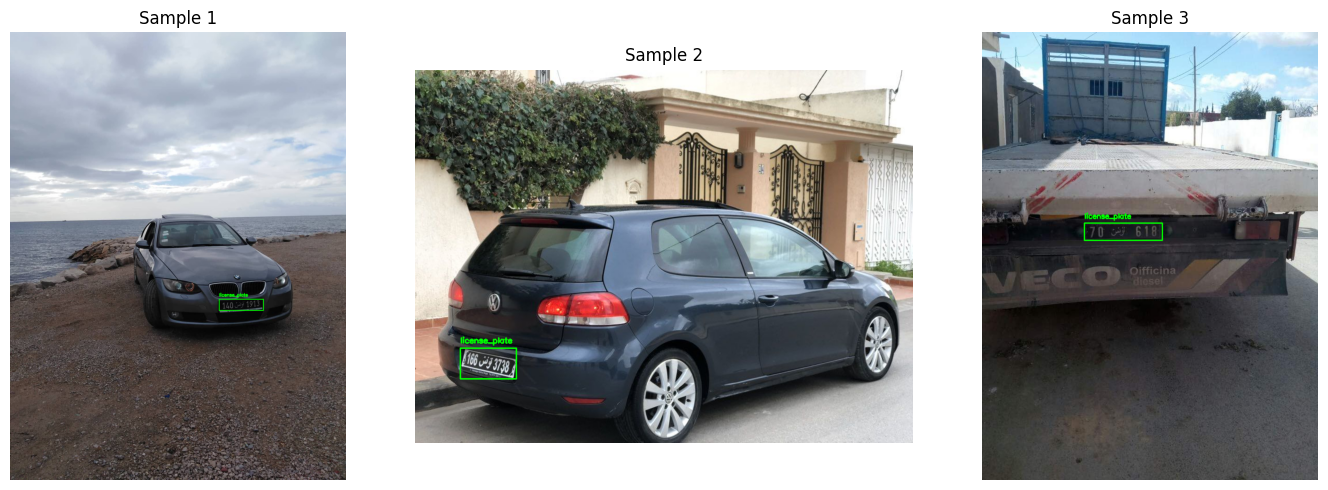

In [ ]:
# Cell 8 (Modified): Visualize a few training examples
def plot_bounding_box_samples(num_samples=3):
    """Plot some sample images with bounding boxes for verification"""
    sample_images = random.sample(train_images, min(num_samples, len(train_images)))

    fig, axes = plt.subplots(1, len(sample_images), figsize=(15, 5))
    if len(sample_images) == 1:
        axes = [axes]

    for i, img_path in enumerate(sample_images):
        # Load image
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Get annotation - use train_image_to_annotation dictionary
        json_path = train_image_to_annotation[img_path]
        with open(json_path, 'r') as f:
            data = json.load(f)

        # Draw bounding boxes
        for obj in data['objects']:
            if obj['classTitle'] == 'license plate':
                points = obj['points']['exterior']
                x1, y1 = points[0]
                x2, y2 = points[1]

                # Draw rectangle
                cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
                cv2.putText(img, 'license_plate', (x1, y1-10),
                           cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

        # Display
        axes[i].imshow(img)
        axes[i].set_title(f"Sample {i+1}")
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# Visualize samples
plot_bounding_box_samples(3)

In [ ]:
# Cell 9 (Alternative): Train YOLOv8 model without torch import
def train_yolo():
    """Train YOLOv8 model for license plate detection"""
    # Load a pre-trained YOLOv8 model
    model = YOLO('yolov8n.pt')  # Nano model (you can also use 's', 'm', or 'l' for larger models)

    # Train the model
    results = model.train(
        data=os.path.join(yolo_dataset_dir, "dataset.yaml"),
        epochs=50,            # Number of training epochs
        imgsz=640,            # Image size
        batch=16,             # Batch size
        patience=10,          # Early stopping patience
        device='0'  # Use GPU if available, will fallback to CPU if GPU not available
    )

    # Return the trained model
    return model

# Train the model
detection_model = train_yolo()

100%|██████████| 6.25M/6.25M [00:00<00:00, 112MB/s]

Ultralytics 8.3.100 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=license_plate_detection/dataset.yaml, epochs=50, time=None, patience=10, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, sh

 15                  -1  1     37248  ultralytics.nn.modules.block.C2f             [192, 64, 1]                  
 16                  -1  1     36992  ultralytics.nn.modules.conv.Conv             [64, 64, 3, 2]                
 17            [-1, 12]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 18                  -1  1    123648  ultralytics.nn.modules.block.C2f             [192, 128, 1]                 
 19                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
 20             [-1, 9]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 21                  -1  1    493056  ultralytics.nn.modules.block.C2f             [384, 256, 1]                 
 22        [15, 18, 21]  1    751507  ultralytics.nn.modules.head.Detect           [1, [64, 128, 256]]           
Model summary: 129 layers, 3,011,043 parameters, 3,011,027 gradients, 8.2 GFLOPs

Transf

100%|██████████| 5.35M/5.35M [00:00<00:00, 110MB/s]


AMP: checks passed ✅


train: Scanning /content/license_plate_detection/labels/train.cache... 567 images, 0 backgrounds, 0 corrupt: 100%|██████████| 567/567 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/license_plate_detection/labels/val.cache... 142 images, 0 backgrounds, 0 corrupt: 100%|██████████| 142/142 [00:00<?, ?it/s]


Plotting labels to runs/detect/train2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train2
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      2.43G      1.316      2.727      1.172         11        640: 100%|██████████| 36/36 [00:13<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.67it/s]

                   all        142        142    0.00331      0.993      0.344       0.24



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      2.65G      1.169      1.576      1.043         12        640: 100%|██████████| 36/36 [00:11<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.33it/s]

                   all        142        142          1      0.601      0.949      0.638



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      2.65G      1.201      1.372      1.041         10        640: 100%|██████████| 36/36 [00:11<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.56it/s]

                   all        142        142      0.913      0.831      0.898      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      2.65G      1.156       1.23      1.056         12        640: 100%|██████████| 36/36 [00:12<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.79it/s]

                   all        142        142      0.955      0.894      0.933      0.643



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      2.65G      1.096      1.061      1.018         16        640: 100%|██████████| 36/36 [00:14<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.93it/s]

                   all        142        142      0.962      0.937      0.967       0.64



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      2.65G      1.131     0.9587      1.041         12        640: 100%|██████████| 36/36 [00:12<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.06it/s]

                   all        142        142      0.975       0.93      0.983      0.665



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      2.65G      1.028      0.848     0.9993         12        640: 100%|██████████| 36/36 [00:12<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.34it/s]

                   all        142        142      0.969      0.951      0.988      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      2.65G      1.069      0.804      1.011         12        640: 100%|██████████| 36/36 [00:12<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.22it/s]

                   all        142        142      0.986      0.964      0.988      0.628



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      2.65G       1.05     0.7694      1.003          9        640: 100%|██████████| 36/36 [00:12<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.44it/s]

                   all        142        142      0.979      0.973      0.994      0.685



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      2.65G       1.03     0.7328     0.9971         10        640: 100%|██████████| 36/36 [00:12<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.10it/s]

                   all        142        142          1      0.979      0.994      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      2.65G     0.9871     0.7166       0.99         12        640: 100%|██████████| 36/36 [00:12<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.31it/s]

                   all        142        142          1      0.948      0.989      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      2.65G     0.9939     0.6694     0.9692         12        640: 100%|██████████| 36/36 [00:12<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.99it/s]

                   all        142        142      0.993      0.958      0.994      0.632



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      2.65G     0.9791     0.6452     0.9658         12        640: 100%|██████████| 36/36 [00:12<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.96it/s]

                   all        142        142      0.986      0.993      0.995      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      2.65G     0.9288     0.6245      0.963         10        640: 100%|██████████| 36/36 [00:12<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]

                   all        142        142      0.992      0.972      0.994      0.689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      2.65G     0.9444     0.6291     0.9645          8        640: 100%|██████████| 36/36 [00:12<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.99it/s]

                   all        142        142          1      0.963      0.994      0.651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      2.65G     0.9349     0.6222     0.9688         15        640: 100%|██████████| 36/36 [00:11<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.82it/s]

                   all        142        142      0.993      0.975      0.994      0.669



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      2.65G     0.9111     0.5916     0.9542         12        640: 100%|██████████| 36/36 [00:12<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.37it/s]

                   all        142        142       0.99      0.979      0.994       0.67



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      2.65G     0.9069     0.5749     0.9513          6        640: 100%|██████████| 36/36 [00:10<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.30it/s]

                   all        142        142      0.997      0.965      0.993      0.694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      2.65G     0.9022     0.5638     0.9368          5        640: 100%|██████████| 36/36 [00:11<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.50it/s]

                   all        142        142          1      0.986      0.995      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      2.65G     0.9098      0.555     0.9405         10        640: 100%|██████████| 36/36 [00:11<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]

                   all        142        142      0.992      0.979      0.993      0.684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      2.65G     0.9246     0.5722     0.9538         12        640: 100%|██████████| 36/36 [00:12<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.79it/s]

                   all        142        142      0.979      0.987      0.995      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      2.65G     0.8659     0.5235     0.9263         17        640: 100%|██████████| 36/36 [00:12<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.33it/s]

                   all        142        142      0.972      0.989      0.993      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      2.65G     0.8564     0.5152     0.9284         14        640: 100%|██████████| 36/36 [00:12<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.19it/s]

                   all        142        142      0.971      0.993      0.994      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      2.65G     0.8737     0.5162     0.9348         11        640: 100%|██████████| 36/36 [00:12<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.33it/s]

                   all        142        142      0.972      0.978      0.993      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      2.65G     0.8521      0.516     0.9176         19        640: 100%|██████████| 36/36 [00:12<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.24it/s]

                   all        142        142      0.992      0.965      0.994      0.748



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      2.65G     0.8316      0.499       0.92         13        640: 100%|██████████| 36/36 [00:12<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.95it/s]

                   all        142        142       0.97      0.986      0.994      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      2.65G     0.8154     0.4943     0.9141         12        640: 100%|██████████| 36/36 [00:12<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.94it/s]

                   all        142        142      0.955      0.979      0.993      0.752



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      2.65G     0.8294      0.497     0.9186         12        640: 100%|██████████| 36/36 [00:12<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.70it/s]

                   all        142        142      0.959      0.986      0.991      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      2.65G     0.8014     0.4811     0.9132          6        640: 100%|██████████| 36/36 [00:13<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.15it/s]

                   all        142        142      0.979      0.986      0.994      0.725



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      2.65G     0.7968     0.4742     0.9055         14        640: 100%|██████████| 36/36 [00:12<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]

                   all        142        142      0.959      0.993      0.994      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      2.65G     0.8008     0.4739     0.9134         10        640: 100%|██████████| 36/36 [00:11<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.83it/s]

                   all        142        142      0.986      0.971       0.99      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      2.65G     0.8101     0.4726      0.907         14        640: 100%|██████████| 36/36 [00:11<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.49it/s]

                   all        142        142      0.992      0.979      0.994       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      2.65G     0.7855     0.4766     0.9107         14        640: 100%|██████████| 36/36 [00:11<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.42it/s]

                   all        142        142      0.945      0.993       0.99      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      2.65G     0.7823     0.4586     0.9176         13        640: 100%|██████████| 36/36 [00:11<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.32it/s]

                   all        142        142      0.964      0.986      0.986      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      2.65G     0.7599     0.4559     0.9054         13        640: 100%|██████████| 36/36 [00:11<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.50it/s]

                   all        142        142      0.966      0.991      0.994      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      2.65G     0.7515      0.435     0.9083         11        640: 100%|██████████| 36/36 [00:11<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.66it/s]

                   all        142        142      0.998      0.979      0.994      0.758



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      2.65G     0.7686     0.4428     0.8931         14        640: 100%|██████████| 36/36 [00:12<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.98it/s]

                   all        142        142      0.992      0.979      0.994       0.75



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      2.65G      0.778     0.4465     0.9031         12        640: 100%|██████████| 36/36 [00:12<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.25it/s]

                   all        142        142      0.974      0.993      0.994      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      2.65G     0.7422     0.4287        0.9         12        640: 100%|██████████| 36/36 [00:12<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.06it/s]

                   all        142        142      0.971      0.993      0.994      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      2.65G     0.7433     0.4392     0.9016          9        640: 100%|██████████| 36/36 [00:13<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.79it/s]

                   all        142        142      0.971      0.993      0.994      0.742


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      2.65G      0.673     0.3891     0.8722          7        640: 100%|██████████| 36/36 [00:14<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.00it/s]

                   all        142        142          1      0.978      0.994      0.746



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      2.65G     0.6815     0.3953     0.8722          7        640: 100%|██████████| 36/36 [00:12<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.77it/s]

                   all        142        142      0.989      0.979      0.994       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      2.65G     0.6575     0.3838     0.8739          6        640: 100%|██████████| 36/36 [00:11<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.50it/s]

                   all        142        142      0.979       0.98      0.994      0.741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      2.65G     0.6519     0.3699     0.8619          7        640: 100%|██████████| 36/36 [00:11<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.58it/s]

                   all        142        142      0.972      0.992      0.994      0.743



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      2.65G      0.648     0.3679     0.8668          7        640: 100%|██████████| 36/36 [00:10<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.40it/s]

                   all        142        142      0.971      0.993      0.994      0.743



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      2.65G     0.6478     0.3606     0.8702          7        640: 100%|██████████| 36/36 [00:10<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.52it/s]

                   all        142        142      0.993      0.986      0.995      0.738
EarlyStopping: Training stopped early as no improvement observed in last 10 epochs. Best results observed at epoch 36, best model saved as best.pt.
To update EarlyStopping(patience=10) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



46 epochs completed in 0.199 hours.
Optimizer stripped from runs/detect/train2/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train2/weights/best.pt, 6.2MB

Validating runs/detect/train2/weights/best.pt...
Ultralytics 8.3.100 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.61it/s]


                   all        142        142      0.998      0.979      0.994      0.755
Speed: 0.2ms preprocess, 2.3ms inference, 0.0ms loss, 4.3ms postprocess per image
Results saved to runs/detect/train2



image 1/1 /content/drive/MyDrive/full_cars_images/test/img/37.jpg: 384x640 1 license_plate, 37.4ms
Speed: 5.3ms preprocess, 37.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/drive/MyDrive/full_cars_images/test/img/26.jpg: 480x640 1 license_plate, 52.3ms
Speed: 2.3ms preprocess, 52.3ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/drive/MyDrive/full_cars_images/test/img/32.jpg: 480x640 1 license_plate, 12.9ms
Speed: 3.4ms preprocess, 12.9ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/drive/MyDrive/full_cars_images/test/img/38.jpg: 384x640 1 license_plate, 14.0ms
Speed: 3.1ms preprocess, 14.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/drive/MyDrive/full_cars_images/test/img/50.jpg: 384x640 1 license_plate, 9.8ms
Speed: 3.1ms preprocess, 9.8ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


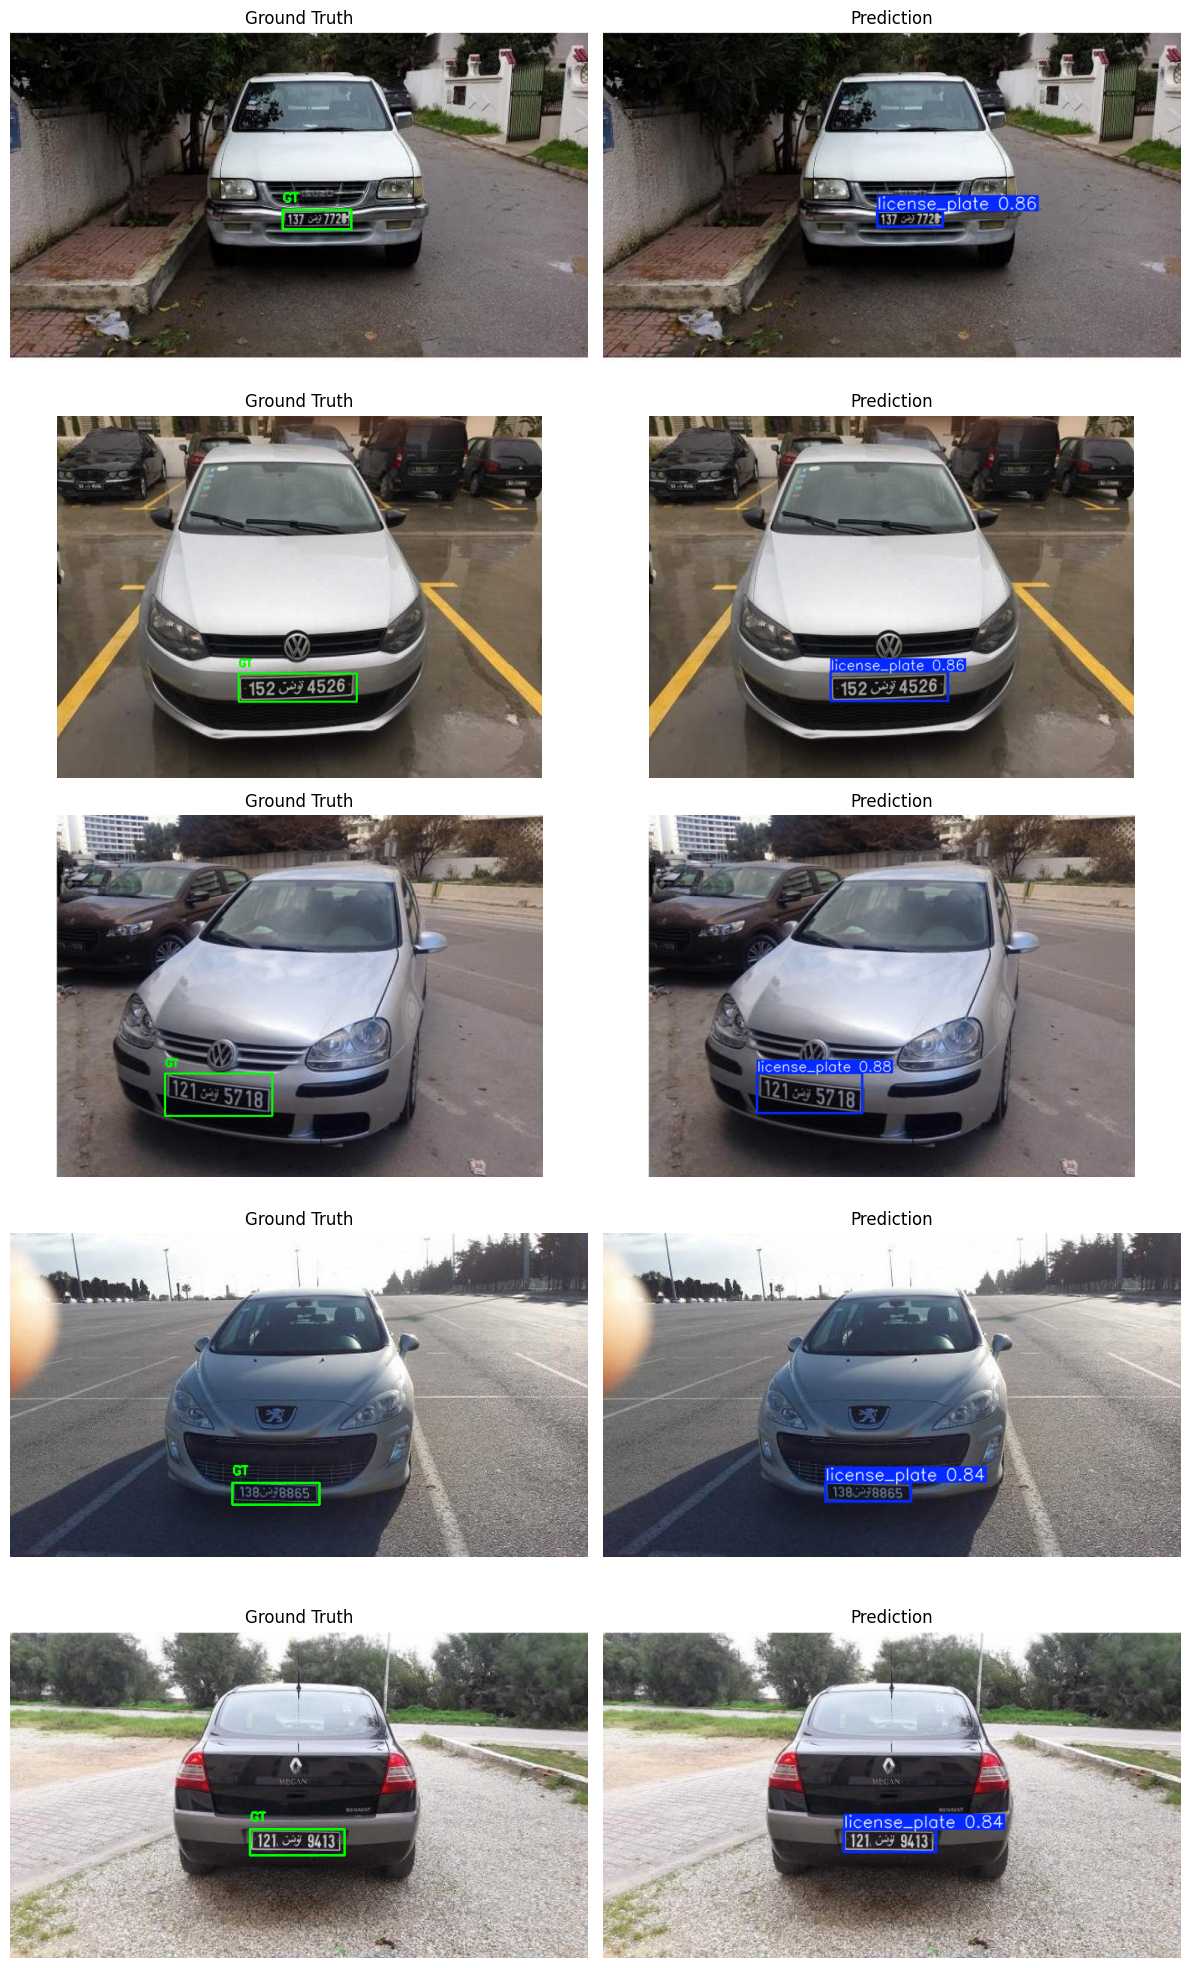

In [ ]:
# Cell 10 (Modified): Test detection model on some validation images
def test_detection_model(model, num_samples=5):
    """Test the trained model on some validation images"""
    # Select random samples from validation set
    test_samples = random.sample(val_images, min(num_samples, len(val_images)))

    # Set up the figure
    fig, axes = plt.subplots(len(test_samples), 2, figsize=(12, 4*len(test_samples)))

    for i, img_path in enumerate(test_samples):
        # Load and display original image with ground truth
        img = cv2.imread(img_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Get ground truth annotation - use test_image_to_annotation
        json_path = test_image_to_annotation[img_path]
        with open(json_path, 'r') as f:
            data = json.load(f)

        # Draw ground truth bounding box
        for obj in data['objects']:
            if obj['classTitle'] == 'license plate':
                points = obj['points']['exterior']
                x1, y1 = points[0]
                x2, y2 = points[1]
                cv2.rectangle(img_rgb, (x1, y1), (x2, y2), (0, 255, 0), 2)
                cv2.putText(img_rgb, 'GT', (x1, y1-10),
                           cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

        # Display ground truth
        axes[i, 0].imshow(img_rgb)
        axes[i, 0].set_title("Ground Truth")
        axes[i, 0].axis('off')

        # Run detection and display predictions
        results = model(img_path)
        res_plotted = results[0].plot()
        res_plotted_rgb = cv2.cvtColor(res_plotted, cv2.COLOR_BGR2RGB)

        # Display prediction
        axes[i, 1].imshow(res_plotted_rgb)
        axes[i, 1].set_title("Prediction")
        axes[i, 1].axis('off')

    plt.tight_layout()
    plt.show()

# Test the model
test_detection_model(detection_model)

In [ ]:
# Cell 11: Save the trained model
detection_model.export(format="onnx")  # Export to ONNX format for deployment
print(f"Model saved to {os.path.join(os.getcwd(), 'yolov8n_license_plate.onnx')}")

Ultralytics 8.3.100 🚀 Python-3.11.11 torch-2.6.0+cu124 CPU (Intel Xeon 2.00GHz)

PyTorch: starting from 'runs/detect/train2/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 5, 8400) (6.0 MB)
requirements: Ultralytics requirements ['onnx>=1.12.0', 'onnxslim', 'onnxruntime-gpu'] not found, attempting AutoUpdate...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 172.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.1/144.1 kB 196.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.8/280.8 MB 233.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 141.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 244.8 MB/s eta 0:00:00

requirements: AutoUpdate success ✅ 18.5s, installed 3 packages: ['onnx>=1.12.0', 'onnxslim', 'onnxruntime-gpu']
requirements: ⚠️ Restart runtime or rerun command for updates to take effect


ONNX: starting export with onnx 1.17.0 opset 19...
ONNX: sl

In [ ]:
# Cell 12: License plate detection function
def detect_license_plates(image, model, conf=0.25):
    """
    Detect license plates in an image using the trained YOLOv8 model

    Args:
        image: Input image (can be a file path or numpy array)
        model: Trained YOLOv8 model
        conf: Confidence threshold for detections

    Returns:
        List of tuples (bbox, confidence) for each detected plate
    """
    # Run inference
    results = model(image, conf=conf)

    # Extract detections
    detections = []

    for result in results:
        boxes = result.boxes
        for box in boxes:
            # Get bbox coordinates
            x1, y1, x2, y2 = box.xyxy[0].cpu().numpy().astype(int)
            confidence = float(box.conf[0].cpu().numpy())

            # Add to detections list
            detections.append(((x1, y1, x2, y2), confidence))

    return detections

# Example usage:
# image = cv2.imread("test_image.jpg")
# detections = detect_license_plates(image, detection_model)
# for (bbox, conf) in detections:
#     print(f"License plate detected at {bbox} with confidence {conf:.2f}")


image 1/1 /content/drive/MyDrive/full_cars_images/test/img/88.jpg: 384x640 1 license_plate, 8.8ms
Speed: 2.4ms preprocess, 8.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/drive/MyDrive/full_cars_images/test/img/112.jpg: 480x640 1 license_plate, 7.3ms
Speed: 2.4ms preprocess, 7.3ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/drive/MyDrive/full_cars_images/test/img/133.jpg: 480x640 1 license_plate, 9.8ms
Speed: 2.5ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/drive/MyDrive/full_cars_images/test/img/116.jpg: 480x640 1 license_plate, 6.4ms
Speed: 2.4ms preprocess, 6.4ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/drive/MyDrive/full_cars_images/test/img/61.jpg: 384x640 1 license_plate, 7.8ms
Speed: 1.9ms preprocess, 7.8ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


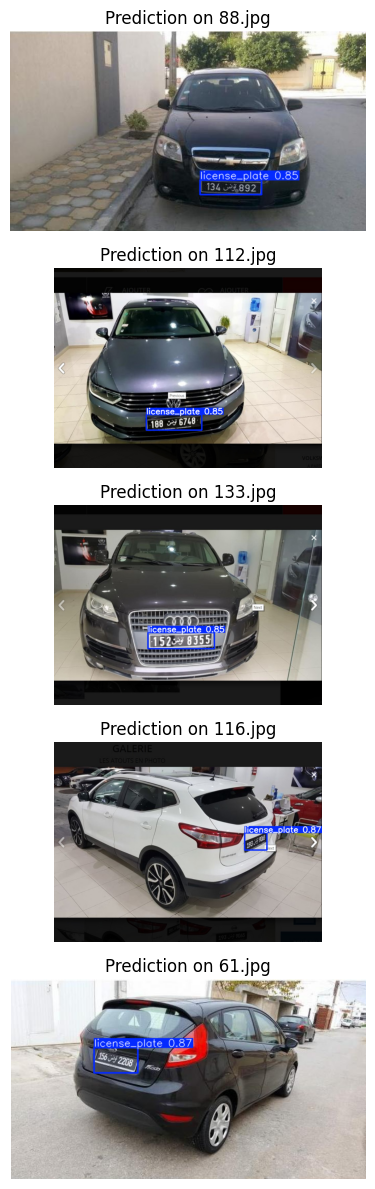

In [28]:
# Cell 13: Visualize some predictions with the trained model
def visualize_predictions():
    # Load the best model
    model = YOLO('runs/detect/train2/weights/best.pt')

    # Select some test images
    test_samples = random.sample(val_images, min(5, len(val_images)))

    plt.figure(figsize=(15, 12))
    for i, img_path in enumerate(test_samples):
        # Run prediction
        results = model(img_path)

        # Get the plotted result
        plotted_img = results[0].plot()
        plotted_img_rgb = cv2.cvtColor(plotted_img, cv2.COLOR_BGR2RGB)

        # Display
        plt.subplot(len(test_samples), 1, i+1)
        plt.imshow(plotted_img_rgb)
        plt.title(f"Prediction on {os.path.basename(img_path)}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Run visualization
visualize_predictions()